# BlackSky v3 — Anomaly Detection using Isolation Forest (TLE/GP‑history based)

This notebook walks you through a reproducible pipeline to score satellites for **suspicious behavior** with an **Isolation Forest** algorithm over historical **TLE** time‑series.

**What we'll do:**

0. Set up dependencies & paths  
0. Load and harmonize TLE GP history from Space‑Track
0. Engineer physically meaningful features
0. Detect anomalies using isolation forest
0. Score and threshold
0. Aggregate per‑satellite
0. Recent anomaly flag
0. Build watchlists
0. Build regime-calibrated watchlists
0. Suspiciousness scores + Exports
0. Dedupe and export final scores

> Tip: Keep 60–180 days of TLE history for best signal, with at least ~10–20 epochs per satellite.

## 0) Setup & Imports

- **Random Seed**: Fix seed (`493`) for reproducibility.  
- **Imports**: 
  - Core libraries: `os`, `pathlib.Path`, `datetime`, `math.sqrt`
  - Data stack: `numpy`, `pandas`
  - ML: `sklearn.ensemble.IsolationForest`, `sklearn.preprocessing.StandardScaler`
  - Visualization: `matplotlib.pyplot`
  - Jupyter config: `InteractiveShell` for displaying all outputs
- **Pandas Display Options**: Show all rows, columns, and full text values.
- **Paths**:
  - Input data: TLE/GP history CSV file (180 days).
  - Output directory: scores written to `../data/out/`.
- **Sanity Check**: Print resolved paths and confirm that the input file exists.

In [1]:
import os

# setting the random seed for reproducibility
import random
random.seed(493)

from math import sqrt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timezone
import matplotlib.pyplot as plt

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Paths
IN_DIR = Path("../data/in")
OUT_DIR = Path("../data/out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

INPUT_CSV = IN_DIR / "tle_gp_history_180days_20250906.csv"
OUTPUT_SCORES = OUT_DIR / "scores.csv"

print(f"Data dir: {IN_DIR.resolve()}\nOut dir:  {OUT_DIR.resolve()}\nInput CSV present? {INPUT_CSV.exists()}" )

Data dir: C:\Users\Dd\OneDrive\Documents\_github\datathon-2025\data\in
Out dir:  C:\Users\Dd\OneDrive\Documents\_github\datathon-2025\data\out
Input CSV present? True


## 1) Load & harmonize TLE history

Expected column name variants are auto‑mapped:

- `NORAD_CAT_ID` or `norad_id`  
- `EPOCH` (ISO)  
- `MEAN_MOTION` (rev/day)  
- `ECCENTRICITY`, `INCLINATION`, `RA_OF_ASC_NODE`, `ARG_OF_PERICENTER`, `BSTAR`

## Column Harmonization + Object Type Enrichment

This section standardizes raw Space-Track/UDL CSVs into a **canonical schema**, applies robust type parsing, and (optionally) enriches each record with a normalized `object_type` (e.g., `PAYLOAD`, `DEBRIS`, `ROCKET BODY`, `UNKNOWN`). It then filters out non-targets (debris and rocket bodies) for downstream anomaly detection.

### What the helpers do
- **`_col(df, names, required=True)`**  
  Convenience finder: returns the first existing column from a list of candidates; raises if none found and `required=True`.

- **`_pick_name(columns, candidates)`**  
  Case-insensitive name resolver. Given a list of candidate spellings (e.g., `["NORAD_CAT_ID","norad_id","catnr"]`), returns the first match in the actual header.

- **`_normalize_object_type(val)`**  
  Normalizes common variants into one of: `PAYLOAD`, `DEBRIS`, `ROCKET BODY`, `UNKNOWN` (e.g., `RB`, `R/B` → `ROCKET BODY`, `PL` → `PAYLOAD`).

### `harmonize_columns(df)`
- **Trims/cleans headers** and maps common variants → canonical names:  
  - `norad_id`, `epoch`, `mean_motion`, `ecc`, `incl`, `raan`, `argp`, `bstar`  
  - Optional passthroughs: `object_type`, `object_name`, `object_id`
- **Validates required fields**; raises with a clear message if missing.
- **Type coercion**:
  - `norad_id` → integer (nullable → coerced, then dropped if missing)
  - `epoch` → UTC timestamp (`format="mixed"`, forgiving to microseconds/ISO variants)
  - Numerics (`mean_motion`, `ecc`, `incl`, `raan`, `argp`, `bstar`) → numeric with coercion
- Drops rows missing **`norad_id` or `epoch`**.

### `attach_object_type(df, catalog_csv=None)`
- If `object_type` already present, normalizes it and returns.
- Else, if `catalog_csv` is provided, minimally harmonizes it (expects **`norad_id`** and **`object_type`** in any common variant), merges, normalizes values.
- Else, creates `object_type="UNKNOWN"` as a fallback.

### Usage in this cell
1. **Load raw** CSV → `raw`.
2. **Harmonize & sort** by `norad_id`, `epoch`.
3. **Ensure `object_type`** (use in-file if present; no catalog backfill here).
4. **Filter** out `DEBRIS` and `ROCKET BODY`.
5. Quick sanity outputs: `value_counts`, `shape`, and `head()`.

### Expected canonical columns (post-harmonize)
- Required: `norad_id`, `epoch`, `mean_motion`, `ecc`, `incl`, `raan`, `argp`, `bstar`  
- Optional if present: `object_type`, `object_name`, `object_id`

### Tips / Gotchas
- If you plan to enrich `object_type`, pass a NORAD/UCS catalog CSV via `catalog_csv=...`.
- Mixed date formats are handled, but truly malformed `epoch` will be coerced to `NaT` and dropped.
- After filtering, verify class balance with `object_type.value_counts()` before modeling.

In [2]:
def _col(df, names, required=True):
    for n in names:
        if n in df.columns: 
            return n
    if required:
        raise KeyError(f"Missing any of columns: {names}")
    return None

# Robust, case-insensitive harmonizer for Space-Track/UDL CSVs
def _pick_name(columns, candidates):
    colset = {c.lower(): c for c in columns}
    for cand in candidates:
        if cand.lower() in colset:
            return colset[cand.lower()]
    return None

def _normalize_object_type(val: str | None) -> str | None:
    if val is None:
        return None
    s = str(val).strip().upper()
    # Common variants -> canonical
    if s in {"PAYLOAD", "P", "PL"}:
        return "PAYLOAD"
    if s in {"DEBRIS", "D", "TBD", "FRAGMENT"}:
        return "DEBRIS"
    if s in {"ROCKET BODY", "RB", "R/B", "ROCKETBODY"}:
        return "ROCKET BODY"
    if s in {"UNKNOWN", "UNK"}:
        return "UNKNOWN"
    # Fallthrough: keep original capitalization reasonable
    return s.title()

def harmonize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Trim/normalize header whitespace
    df.columns = [str(c).strip() for c in df.columns]

    # Map variants → canonical names (case-insensitive)
    name_map = {}
    name_map[_pick_name(df.columns, ["NORAD_CAT_ID","norad_cat_id","norad_id","catnr","satno","norad"])] = "norad_id"
    name_map[_pick_name(df.columns, ["EPOCH","epoch","TLE_EPOCH","GP_EPOCH","epochutc","epoch_time"])] = "epoch"
    name_map[_pick_name(df.columns, ["MEAN_MOTION","mean_motion","N","meanmo"])] = "mean_motion"
    name_map[_pick_name(df.columns, ["ECCENTRICITY","eccentricity","ECC","ecc"])] = "ecc"
    name_map[_pick_name(df.columns, ["INCLINATION","inclination","INCL","incl"])] = "incl"
    name_map[_pick_name(df.columns, ["RA_OF_ASC_NODE","raan","RAAN","node_raan","node"])] = "raan"
    name_map[_pick_name(df.columns, ["ARG_OF_PERICENTER","argp","ARG_OF_PERIGEE","AOP"])] = "argp"
    name_map[_pick_name(df.columns, ["BSTAR","bstar","BSTAR_DRAG","bstar_drag_term"])] = "bstar"
    # Optional descriptive columns
    ot = _pick_name(df.columns, ["OBJECT_TYPE","object_type","type"])
    on = _pick_name(df.columns, ["OBJECT_NAME","object_name","satname","sat_name","name"])
    oid = _pick_name(df.columns, ["OBJECT_ID","object_id","INTLDES","intl_des","intl_desig","international_designator"])
    if ot:  name_map[ot]  = "object_type"
    if on:  name_map[on]  = "object_name"
    if oid: name_map[oid] = "object_id"

    # Drop missing keys (None) from the mapping
    name_map = {k: v for k, v in name_map.items() if k is not None}

    # Apply renames
    df = df.rename(columns=name_map)

    # Validate required
    required = ["norad_id","epoch","mean_motion","ecc","incl","raan","argp","bstar"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(
            f"Missing expected columns after harmonization: {missing}\n"
            f"Incoming columns: {list(df.columns)}"
        )

    # Types
    df["norad_id"] = pd.to_numeric(df["norad_id"], errors="coerce").astype("Int64")

    # Be forgiving on timestamp formats (mixed ISO8601, with/without micros)
    df["epoch"] = pd.to_datetime(df["epoch"], utc=True, format="mixed", errors="coerce")

    # Numerics
    for c in ["mean_motion","ecc","incl","raan","argp","bstar"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Normalize object_type if present
    if "object_type" in df.columns:
        df["object_type"] = df["object_type"].map(_normalize_object_type)

    # Drop rows lacking id or epoch
    df = df.dropna(subset=["norad_id","epoch"]).copy()
    df["norad_id"] = df["norad_id"].astype(int)

    return df

def attach_object_type(df: pd.DataFrame, catalog_csv: str | None = None) -> pd.DataFrame:
    """
    If df already has object_type, just returns df with normalized values.
    If not, optionally merges in a catalog CSV that contains at least:
        - norad_id
        - object_type  (values like 'PAYLOAD', 'DEBRIS', 'ROCKET BODY', 'UNKNOWN')
    """
    df = df.copy()

    if "object_type" in df.columns and df["object_type"].notna().any():
        # ensure normalized
        df["object_type"] = df["object_type"].map(_normalize_object_type)
        return df

    if catalog_csv is None:
        # no source to backfill; create column with UNKNOWN
        df["object_type"] = "UNKNOWN"
        return df

    cat = pd.read_csv(catalog_csv)
    # Try to harmonize minimal columns in catalog too
    cat_cols = [str(c).strip() for c in cat.columns]
    ncol = _pick_name(cat_cols, ["NORAD_CAT_ID","norad_cat_id","norad_id","catnr","satno","norad"])
    ocol = _pick_name(cat_cols, ["OBJECT_TYPE","object_type","type"])
    if not ncol or not ocol:
        raise KeyError("Catalog CSV must have norad_id and object_type (in any common variant).")

    cat = cat.rename(columns={ncol: "norad_id", ocol: "object_type"})
    cat["norad_id"] = pd.to_numeric(cat["norad_id"], errors="coerce").astype("Int64")
    cat = cat.dropna(subset=["norad_id"]).copy()
    cat["norad_id"] = cat["norad_id"].astype(int)
    cat["object_type"] = cat["object_type"].map(_normalize_object_type)

    df = df.merge(
        cat[["norad_id","object_type"]],
        on="norad_id",
        how="left",
        suffixes=("","_cat")
    )

    # prefer existing (if any), else catalog, else UNKNOWN
    if "object_type" not in df.columns:
        df["object_type"] = df["object_type_cat"]
    else:
        df["object_type"] = df["object_type"].fillna(df["object_type_cat"])
    df.drop(columns=[c for c in ["object_type_cat"] if c in df.columns], inplace=True)
    df["object_type"] = df["object_type"].fillna("UNKNOWN")

    return df

# ---- Usage ------------------------------------------------------
raw = pd.read_csv(INPUT_CSV)
raw = harmonize_columns(raw).sort_values(["norad_id","epoch"]).reset_index(drop=True)

# Ensure object_type is attached
raw = attach_object_type(raw, catalog_csv=None)

# 🔽 Drop unwanted object types
raw = raw[~raw["object_type"].isin(["DEBRIS", "ROCKET BODY"])].reset_index(drop=True)

raw["object_type"].value_counts(dropna=False)
raw.shape
raw.head()


object_type
PAYLOAD    5984549
UNKNOWN     400111
Name: count, dtype: int64

(6384660, 11)

,norad_id,epoch,mean_motion,ecc,incl,raan,argp,bstar,object_type,object_name,object_id
0,5,2025-03-13 06:36:18.533664+00:00,10.858913,0.184160,34.2545,296.9251,220.3536,0.000432,PAYLOAD,VANGUARD 1,1958-002B
1,5,2025-03-13 06:36:18.533664+00:00,10.858913,0.184160,34.2545,296.9251,220.3536,0.000432,PAYLOAD,VANGUARD 1,1958-002B
2,5,2025-03-14 06:52:53.001120+00:00,10.858920,0.184164,34.2550,293.8035,224.9139,0.000448,PAYLOAD,VANGUARD 1,1958-002B
3,5,2025-03-14 22:19:49.184832+00:00,10.858924,0.184167,34.2552,291.8171,227.8154,0.000431,PAYLOAD,VANGUARD 1,1958-002B
4,5,2025-03-15 07:09:30.415680+00:00,10.858927,0.184169,34.2556,290.6819,229.4736,0.000443,PAYLOAD,VANGUARD 1,1958-002B


## 2) Feature engineering

This cell derives **physics-informed features** from harmonized TLE/GP data, with special focus on RAAN drift vs. the J2 perturbation model. These features will feed the anomaly detector.

### Constants
- `MU_EARTH = 398600.4418` km³/s² (Earth’s GM)  
- `R_EARTH = 6378.137` km (equatorial radius)  
- `J2 = 1.08262668e-3` (zonal harmonic for oblateness)

### Helper Functions

- **`mean_motion_revday_to_rads(n_revday)`**  
  Converts mean motion from revolutions per day to radians per second:  
  n_rad/s = n_rev/day × (2π / 86400)

- **`semimajor_axis_from_mean_motion(n_revday)`**  
  From Kepler’s third law:  
  a = ( μ / n² )^(1/3)  
  where n is in rad/s and μ is the Earth’s gravitational parameter.

- **`unwrap_deg(series_deg)`**  
  Angle unwrapping in degrees (handles 0–360° wraparound) to enable stable differencing of angular elements.

- **`expected_raan_drift_deg_per_day(a, e, i)`**  
  J2 secular RAAN drift (classical approximation):  
  dΩ/dt ≈ -(3/2) · J2 · (Re/a)² · (n · cos(i)) / (1 - e²)²  
  Units: rad/s, converted to deg/day.  
  Used to compute an expected RAAN drift baseline.


### `build_features(df, window_days=7.0)`
Pipeline (per `norad_id`, sorted by `epoch`):

1. **Harmonize & sort**  
   Uses `harmonize_columns` to ensure canonical fields, then chronological order.

2. **Geometry & periods**
   - `a_km` from mean motion  
   - `period_min = 1440 / mean_motion` (safe-clipped)  
   - Apoapsis/Periapsis altitude (km):  
     `apo_km = a(1+e) - R_EARTH`, `per_km = a(1-e) - R_EARTH`

3. **Angle unwrapping**  
   - `raan_unw`, `argp_unw` for robust deltas across 0/360° boundaries.

4. **Time deltas**  
   - `dt_days` = consecutive epoch diffs in days (tiny/zero set to NaN to avoid divide-by-zero artifacts).

5. **First differences & rates**  
   For each of `mean_motion, ecc, incl, raan_unw, argp_unw, bstar, a_km, apo_km, per_km`:
   - `d_<col>` = first difference
   - `<col>_rate` = `d_<col> / dt_days`

6. **RAAN drift residual**  
   - `raan_rate_exp` from J2 model (deg/day)  
   - `raan_rate_resid = raan_unw_rate - raan_rate_exp`  
   This residual flags **maneuvers** or non-J2 behavior.

7. **Rolling stability (≈window_days)**  
   Adaptive rolling window (min 3 samples) per satellite:  
   - `mm_std, incl_std, ecc_std, bstar_std, raan_resid_std`  
   Captures short-term variability (jitter/instability).

8. **Feature selection & sanitization**  
   Returns rows where **all training features are finite**.

### Output Columns
- **Identifiers**: `norad_id`, `epoch`  
- **Geometry/State**: `period_min`, `a_km`, `apo_km`, `per_km`, `mean_motion`, `ecc`, `incl`, `bstar`  
- **Dynamics (1st diffs & rates)**:  
  `d_mean_motion`, `mean_motion_rate`, `d_ecc`, `ecc_rate`, `d_incl`, `incl_rate`  
- **RAAN diagnostics**: `raan_rate_resid`, `raan_resid_std`  
- **Stability (rolling std)**: `mm_std`, `incl_std`, `ecc_std`, `bstar_std`

### Notes & Gotchas
- **Units**: angles in degrees, rates in **per day** where applicable.  
- **Edge cases**: sparse time series yield NaNs until enough points accumulate; these rows are dropped at the end.  
- **Physical interpretation**: large positive/negative `raan_rate_resid` or spikes in `*_std` often correlate with maneuvers or TLE fit changes.

The final lines run the builder with a 7-day context window and preview shape and samples.

In [3]:
MU_EARTH = 398600.4418  # km^3/s^2
R_EARTH = 6378.137      # km
J2 = 1.08262668e-3

def mean_motion_revday_to_rads(n_revday: np.ndarray) -> np.ndarray:
    return n_revday * 2*np.pi / 86400.0

def semimajor_axis_from_mean_motion(n_revday: np.ndarray) -> np.ndarray:
    n = mean_motion_revday_to_rads(n_revday)
    a = (MU_EARTH / (n**2))**(1/3)
    return a

def unwrap_deg(series_deg: pd.Series) -> pd.Series:
    rad = np.deg2rad(series_deg.values.astype(float))
    unwrapped = np.unwrap(rad)
    return pd.Series(np.rad2deg(unwrapped), index=series_deg.index)

def expected_raan_drift_deg_per_day(a_km, ecc, incl_deg):
    # dΩ/dt ≈ -1.5 * J2 * (Re/a)^2 * n * cos(i) / (1 - e^2)^2   [rad/s]
    n = np.sqrt(MU_EARTH / (a_km**3))  # rad/s
    i = np.deg2rad(incl_deg)
    factor = -1.5 * J2 * (R_EARTH/a_km)**2 * n * np.cos(i) / ((1 - ecc**2)**2)
    return factor * 86400.0 * 180.0/np.pi  # deg/day

def build_features(df: pd.DataFrame, window_days: float = 7.0) -> pd.DataFrame:
    df = harmonize_columns(df).sort_values(["norad_id","epoch"]).reset_index(drop=True)

    # geometry
    df["a_km"] = semimajor_axis_from_mean_motion(df["mean_motion"])
    df["period_min"] = 1440.0 / df["mean_motion"].clip(lower=1e-12)  # avoid blowups
    df["apo_km"] = df["a_km"] * (1 + df["ecc"]) - R_EARTH
    df["per_km"] = df["a_km"] * (1 - df["ecc"]) - R_EARTH

    # unwrap before differencing
    df["raan_unw"] = df.groupby("norad_id", group_keys=False)["raan"].apply(unwrap_deg)
    df["argp_unw"] = df.groupby("norad_id", group_keys=False)["argp"].apply(unwrap_deg)

    # time deltas (days)
    df["dt_days"] = df.groupby("norad_id")["epoch"].diff().dt.total_seconds() / 86400.0
    # treat tiny/zero dt as NaN to avoid infs
    df.loc[df["dt_days"].abs() < 1e-9, "dt_days"] = np.nan

    # first differences + safe rates
    cols = ["mean_motion","ecc","incl","raan_unw","argp_unw","bstar","a_km","apo_km","per_km"]
    for col in cols:
        d = df.groupby("norad_id")[col].diff()
        df[f"d_{col}"] = d
        df[f"{col}_rate"] = d / df["dt_days"]  # NaN if dt_days is NaN

    # RAAN drift residual vs J2
    df["raan_rate_exp"] = expected_raan_drift_deg_per_day(df["a_km"], df["ecc"], df["incl"])
    df["raan_rate_resid"] = df["raan_unw_rate"] - df["raan_rate_exp"]

    # rolling stats
    def rolling_feats(g):
        if len(g) < 3:
            return g.assign(mm_std=np.nan, incl_std=np.nan, ecc_std=np.nan, bstar_std=np.nan, raan_resid_std=np.nan)
        med_dt = np.nanmedian(g["dt_days"].values[1:]) if g["dt_days"].notna().any() else 1.0
        win = max(3, int(round(window_days / max(med_dt, 1e-6))))
        roll = g.rolling(win, min_periods=3)
        return g.assign(
            mm_std = roll["mean_motion"].std().values,
            incl_std = roll["incl"].std().values,
            ecc_std = roll["ecc"].std().values,
            bstar_std = roll["bstar"].std().values,
            raan_resid_std = roll["raan_rate_resid"].std().values,
        )
    df = df.groupby("norad_id", group_keys=False).apply(rolling_feats)

    feats = df[[
        "norad_id","epoch",
        "period_min","a_km","apo_km","per_km",
        "mean_motion","ecc","incl","bstar",
        "d_mean_motion","mean_motion_rate",
        "d_ecc","ecc_rate",
        "d_incl","incl_rate",
        "raan_rate_resid","raan_resid_std",
        "mm_std","incl_std","ecc_std","bstar_std",
    ]].copy()

    # drop rows with non-finite in any feature we’ll train on
    feature_cols = [
        "period_min","a_km","apo_km","per_km",
        "mean_motion","ecc","incl","bstar",
        "d_mean_motion","mean_motion_rate",
        "d_ecc","ecc_rate","d_incl","incl_rate",
        "raan_rate_resid","raan_resid_std",
        "mm_std","incl_std","ecc_std","bstar_std",
    ]
    feats = feats[np.isfinite(feats[feature_cols]).all(axis=1)].reset_index(drop=True)
    return feats

feats = build_features(raw, window_days=7.0)
feats.shape
feats.head(7)

C:\Users\Dd\AppData\Local\Temp\ipykernel_27120\1795540671.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("norad_id", group_keys=False).apply(rolling_feats)


(5235815, 22)

,norad_id,epoch,period_min,a_km,apo_km,per_km,mean_motion,ecc,incl,bstar,d_mean_motion,mean_motion_rate,d_ecc,ecc_rate,d_incl,incl_rate,raan_rate_resid,raan_resid_std,mm_std,incl_std,ecc_std,bstar_std
0,5,2025-03-15 07:09:30.415680+00:00,132.609790,8614.113117,3822.427854,649.524379,10.858927,0.184169,34.2556,0.000443,2.910000e-06,0.000008,1.600000e-06,4.349737e-06,0.0004,0.001087,-0.003950,0.000138,0.000006,0.000472,0.000004,0.000008
1,5,2025-03-15 15:59:12.044832+00:00,132.609769,8614.112244,3822.442326,649.508162,10.858928,0.184171,34.2559,0.000420,1.650000e-06,0.000004,1.800000e-06,4.893393e-06,0.0003,0.000816,-0.004189,0.000208,0.000007,0.000552,0.000005,0.000010
2,5,2025-03-17 05:30:28.576224+00:00,132.609613,8614.105464,3822.479952,649.456976,10.858941,0.184176,34.2570,0.000450,1.282000e-05,0.000008,5.300000e-06,3.390078e-06,0.0011,0.000704,-0.003703,0.000206,0.000009,0.000820,0.000006,0.000010
3,5,2025-03-17 20:57:30.513312+00:00,132.609546,8614.102561,3822.479960,649.451162,10.858947,0.184176,34.2572,0.000456,5.490000e-06,0.000009,4.000000e-07,6.213376e-07,0.0002,0.000311,-0.003401,0.000269,0.000011,0.000938,0.000006,0.000012
4,5,2025-03-17 23:09:56.611584+00:00,132.609537,8614.102201,3822.480395,649.450007,10.858947,0.184176,34.2572,0.000455,6.800000e-07,0.000007,1.000000e-07,1.087326e-06,0.0000,0.000000,-0.003670,0.000251,0.000011,0.000909,0.000005,0.000012
5,5,2025-03-20 19:35:38.560992+00:00,132.609235,8614.089117,3822.496774,649.407461,10.858972,0.184180,34.2580,0.000494,2.474000e-05,0.000009,3.700000e-06,1.297708e-06,0.0008,0.000281,-0.003442,0.000301,0.000015,0.000894,0.000004,0.000021
6,5,2025-03-21 19:52:36.160320+00:00,132.609135,8614.084765,3822.481283,649.414247,10.858980,0.184179,34.2580,0.000493,8.230000e-06,0.000008,-1.200000e-06,-1.186031e-06,0.0000,0.000000,-0.003300,0.000321,0.000019,0.000869,0.000004,0.000025


## 3) Orbital Regime Tagging

To provide categorical context, each satellite state is assigned an **orbital regime** label based on altitude and period heuristics. This enables regime-specific analysis (e.g., comparing anomalies in LEO vs GEO).

### Function: `tag_regime(row)`
- **Mean altitude**: average of apoapsis and periapsis (`apo_km`, `per_km`).
- **Decision logic**:
  1. **Geostationary (GEO)**  
     If orbital period ≈ 1436 minutes (24 hours), within ±30 min tolerance.  
     (Catches near-synchronous orbits even if altitude is slightly off due to eccentricity.)
  2. **Low Earth Orbit (LEO)**  
     If mean altitude < 2000 km.
  3. **Medium Earth Orbit (MEO)**  
     If mean altitude below GEO but ≥ 2000 km (specifically < ~34,786 km).
  4. **Highly Elliptical Orbit (HEO)**  
     Anything else (typically high-eccentricity, long-period orbits).

### Example Output
- Adds a new column: `regime`
- `value_counts()` shows distribution of samples across regimes (top 5).

### Why this matters
- Regime determines **expected orbital dynamics** and helps calibrate anomaly thresholds.
- For example:
  - LEO: frequent drag/maneuvers, shorter lifetimes.
  - GEO: station-keeping signatures, very stable RAAN drift expectations.
  - MEO: navigation constellations (e.g., GNSS).
  - HEO: specialized orbits (e.g., Molniya).

In [4]:
def tag_regime(row):
    alt_mean = (row["apo_km"] + row["per_km"]) / 2.0
    if abs(row["period_min"] - 1436) < 30: 
        return "GEO"
    if alt_mean < 2000:
        return "LEO"
    if alt_mean < (35786 - 1000):
        return "MEO"
    return "HEO"

feats["regime"] = feats.apply(tag_regime, axis=1)
feats["regime"].value_counts().head()

regime
LEO    4765146
GEO     365088
MEO      83650
HEO      21931
Name: count, dtype: int64

## 4) Anomaly Modeling with Isolation Forest

This cell prepares model features, scales them for comparability, and fits an **Isolation Forest** to detect outliers (potentially suspicious satellite behavior). It then attaches per-row anomaly scores and labels back to `feats`.

### 1) Feature matrix
We select physics-informed features only (no IDs/timestamps/labels):
- Geometry/state: `period_min, a_km, apo_km, per_km, mean_motion, ecc, incl, bstar`
- Short-term dynamics (diffs & rates): `d_mean_motion, mean_motion_rate, d_ecc, ecc_rate, d_incl, incl_rate`
- RAAN diagnostics: `raan_rate_resid, raan_resid_std`
- Stability (rolling std): `mm_std, incl_std, ecc_std, bstar_std`

> Result: `X = feats[feature_cols].values`

### 2) Scaling
- **Why**: features have different units/magnitudes; scaling avoids dominance by large-scale features.
- **How**: `StandardScaler` → zero mean, unit variance across the entire dataset.

> Note: For production/validation, **fit the scaler on train only** (time-aware split), then transform val/test to avoid leakage.

### 3) Isolation Forest
Key settings:
- `n_estimators=200`: more trees → smoother isolation estimates.
- `max_samples="auto"`: uses min(256, n_samples) per tree (good default).
- `contamination=0.01`: prior on anomaly fraction (tune per regime/dataset).
- `random_state=42`: reproducibility (separate from the global `random.seed(493)`).
- `n_jobs=-1`: use all cores.

Fit on `Xs` (scaled features).

### 4) Outputs & interpretation
- `anomaly_score = iso.decision_function(Xs)`  
  Higher = **more normal**, lower = **more anomalous**. Values are centered so that ~0 is the decision boundary given `contamination`.
- `anomaly_label = iso.predict(Xs)`  
  `1` = inlier (normal), `-1` = outlier (anomaly).

Quick sanity checks:
- Class balance via `value_counts()`.
- Sample preview with `[['norad_id','epoch','regime','anomaly_score','anomaly_label']]`.

### Tuning & best practices
- **Contamination**: Start with 0.5–2% in LEO, lower in GEO; consider **per-regime models** or at least per-regime thresholds.
- **Temporal validation**: Use a **forward-chaining** split (train on earlier epochs, validate on later) to reflect real-time use.
- **Thresholding**: If you need a continuous “suspiciousness” score:
  - `suspiciousness = -anomaly_score` (higher = more suspicious), and/or
  - Map to **percentile ranks** within regime to make thresholds interpretable.
- **Diagnostics**: `iso.feature_importances_` (mean impurity decrease) can give a rough sense of which features drive isolation (use with caution).
- **Persistence**: Save `scaler` and `iso` (e.g., via `joblib`) to ensure consistent scoring outside the notebook.

In [5]:
# --- Pick feature columns (exclude IDs, time, labels)
feature_cols = [
    'period_min','a_km','apo_km','per_km',
    'mean_motion','ecc','incl','bstar',
    'd_mean_motion','mean_motion_rate',
    'd_ecc','ecc_rate',
    'd_incl','incl_rate',
    'raan_rate_resid','raan_resid_std',
    'mm_std','incl_std','ecc_std','bstar_std'
]

X = feats[feature_cols].values

# --- Scale features for comparability
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# --- Train Isolation Forest
iso = IsolationForest(
    n_estimators=200,     # number of trees
    max_samples="auto",   # subsample size
    contamination=0.01,   # expected fraction of anomalies (tune this!)
    random_state=42,
    n_jobs=-1
)
iso.fit(Xs)

# --- Get anomaly scores/predictions
feats['anomaly_score'] = iso.decision_function(Xs)   # higher = more normal
feats['anomaly_label'] = iso.predict(Xs)             # -1 = anomaly, 1 = normal

# --- Quick check
feats['anomaly_label'].value_counts()
feats[['norad_id','epoch','regime','anomaly_score','anomaly_label']].head()

IsolationForest(contamination=0.01, n_estimators=200, n_jobs=-1,
                random_state=42)

anomaly_label
 1    5183456
-1      52359
Name: count, dtype: int64

,norad_id,epoch,regime,anomaly_score,anomaly_label
0,5,2025-03-15 07:09:30.415680+00:00,MEO,0.149593,1
1,5,2025-03-15 15:59:12.044832+00:00,MEO,0.151651,1
2,5,2025-03-17 05:30:28.576224+00:00,MEO,0.147914,1
3,5,2025-03-17 20:57:30.513312+00:00,MEO,0.150105,1
4,5,2025-03-17 23:09:56.611584+00:00,MEO,0.153871,1


## 5) Satellite-Level Anomaly Aggregation

Up to now, anomaly detection was **per epoch** (row-level).  
Here, we roll results up to the **satellite level** (`norad_id`, `regime`) to identify consistently suspicious objects.

### Aggregated metrics
For each satellite:
- **`mean_score`**: average anomaly score across epochs (higher = more normal).
- **`std_score`**: variability of anomaly scores (unstable behavior = higher std).
- **`n_obs`**: number of epochs available (data coverage).
- **`frac_anom`**: fraction of epochs flagged as anomalies (`anomaly_label = -1`).

### Visualization
A histogram of `frac_anom` shows:
- Most satellites cluster near 0.0 (few anomalies).
- A long tail toward higher fractions = satellites with recurring suspicious behavior.

### Why it matters
- `frac_anom` helps distinguish between **one-off anomalies** (possible TLE fit issues) vs **persistent anomalies** (maneuvers, unusual orbital behavior).
- Sorting by `mean_score` highlights the most anomalous satellites overall.
- Combined with `regime`, this can reveal if certain orbital classes (e.g., GEO vs LEO) show systematically different anomaly distributions.

### Next steps
- Inspect `agg.head(10)` for the most anomalous satellites.
- Consider thresholding (e.g., satellites with `frac_anom > 0.1` or `mean_score < -0.05`) to build a **watchlist**.
- Visualize regime breakdowns (e.g., boxplots of `frac_anom` per `regime`).

(array([1.5211e+04, 3.8300e+02, 2.4700e+02, 1.5300e+02, 8.6000e+01,
        4.7000e+01, 5.0000e+01, 1.9000e+01, 1.2000e+01, 6.0000e+00,
        9.0000e+00, 5.0000e+00, 1.3000e+01, 6.0000e+00, 2.0000e+00,
        8.0000e+00, 8.0000e+00, 8.0000e+00, 6.0000e+00, 4.0000e+00,
        8.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00,
        4.0000e+00, 5.0000e+00, 9.0000e+00, 1.3000e+01, 1.4100e+02]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

Text(0.5, 0, 'Fraction of anomalous epochs')

Text(0, 0.5, 'Number of satellites')

Text(0.5, 1.0, 'Anomaly fraction distribution per satellite')

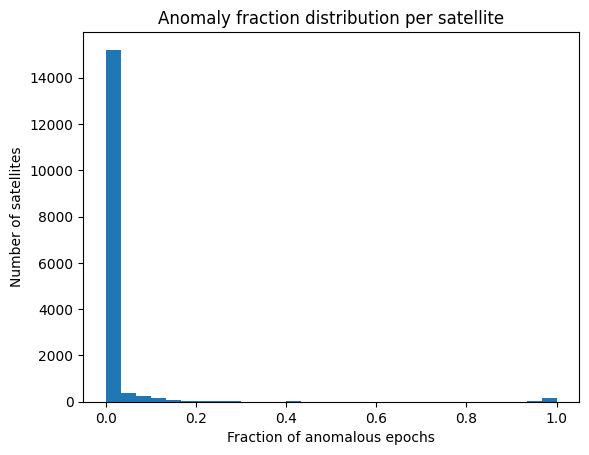

,norad_id,regime,mean_score,std_score,n_obs,frac_anom
15451,64784,HEO,-0.213854,0.005612,4,1.0
14017,63199,MEO,-0.205295,NaN,1,1.0
15452,64784,MEO,-0.198347,0.013646,5,1.0
2361,26463,HEO,-0.185762,0.013347,135,1.0
13705,62852,HEO,-0.181774,0.008261,53,1.0
4169,44625,HEO,-0.179838,0.002400,3,1.0
15391,64723,HEO,-0.179598,0.026581,5,1.0
13374,62483,MEO,-0.177528,0.002419,4,1.0
13373,62483,HEO,-0.174379,0.012161,27,1.0
3889,43435,HEO,-0.171633,NaN,1,1.0


In [6]:
# --- Aggregate anomaly scores per satellite
agg = (
    feats.groupby(['norad_id','regime'])
         .agg(
             mean_score = ('anomaly_score','mean'),
             std_score  = ('anomaly_score','std'),
             n_obs      = ('anomaly_score','size'),
             frac_anom  = ('anomaly_label', lambda x: (x==-1).mean())
         )
         .reset_index()
         .sort_values('mean_score')
)

import matplotlib.pyplot as plt

# --- Quick histogram of fraction anomalies
plt.hist(agg['frac_anom'], bins=30)
plt.xlabel("Fraction of anomalous epochs")
plt.ylabel("Number of satellites")
plt.title("Anomaly fraction distribution per satellite")
plt.show()

agg.head(10)

## 6) 7-Day Anomaly “Latch” Features (time-window flags)

We convert row-level anomaly labels into **time-window signals** per satellite to capture short-term persistence.

### Preconditions
- Ensure `epoch` is a proper UTC datetime and rows are sorted by `norad_id, epoch`.
- Ensure a binary flag exists:
  - `is_anomaly` = `1` if `anomaly_label == -1`, else `0`.

### What `add_7d_latch` does (per `norad_id`)
Uses **time-based rolling windows** (aligned on `epoch`) to compute, for each timestamp, the stats over the **preceding 7 days**:

- **`sat_7d_latch`** = rolling **max** of `is_anomaly` over 7 days  
  → `1` if *any* anomaly occurred in the last 7 days, else `0`.  
  Think of it as a **sticky alert** that stays on for a week after an anomaly.

- **`sat_7d_anom_count`** = rolling **sum** over 7 days  
  → Number of anomalous epochs in the last week.

- **`sat_7d_anom_frac`** = rolling **sum / count** over 7 days  
  → Fraction of epochs anomalous in the last week (coverage-aware).

Implementation details:
- Groups by satellite (`norad_id`), sorts by time, sets `epoch` as index, and applies `.rolling("7D")` with `min_periods=1` to avoid early NaNs.
- Returns numpy arrays to preserve the original row order.

### Why this helps
- Converts spiky, per-epoch anomalies into **short-term persistence signals**, useful for:
  - Ranking recent activity (`sat_7d_anom_count`, `sat_7d_anom_frac`)
  - Alerting/UX (the **latch** stays on after an event)
  - Regime-specific thresholds and watchlist logic

### Quick inspection
The final preview sorts by `anomaly_score` (ascending = most anomalous) and shows:
`norad_id, epoch, regime, anomaly_score, is_anomaly, sat_7d_latch, sat_7d_anom_count, sat_7d_anom_frac`.

### Tips / Gotchas
- **Duplicate timestamps** per satellite will inflate counts; deduplicate if needed.
- **Irregular sampling**: `sat_7d_anom_frac` accounts for the number of observations (`count`) rather than elapsed time. If cadence varies a lot, consider **time-weighted** fractions.
- **Timezone**: everything is coerced to UTC to keep rolling windows consistent.
- If you later change the anomaly model, recompute `is_anomaly` before these features.


In [7]:
# Ensure datetime + sorted
feats = feats.copy()
feats["epoch"] = pd.to_datetime(feats["epoch"], utc=True, errors="coerce")
feats = feats.sort_values(["norad_id","epoch"]).reset_index(drop=True)

# Ensure binary anomaly flag exists (1=anomaly, 0=normal)
if "is_anomaly" not in feats.columns:
    feats["is_anomaly"] = (feats["anomaly_label"] == -1).astype(int)

def add_7d_latch(g):
    g = g.sort_values("epoch").copy()
    # use time-based rolling within the group; keep row order
    ra = (
        g.set_index("epoch")["is_anomaly"]
         .rolling("7D", min_periods=1).max()
         .to_numpy()
    )
    rc = (
        g.set_index("epoch")["is_anomaly"]
         .rolling("7D", min_periods=1).sum()
         .to_numpy()
    )
    rn = (
        g.set_index("epoch")["is_anomaly"]
         .rolling("7D", min_periods=1).count()
         .to_numpy()
    )
    g["sat_7d_latch"]      = ra.astype(int)
    g["sat_7d_anom_count"] = rc.astype(int)
    g["sat_7d_anom_frac"]  = (rc / rn).astype(float)
    return g

# Apply per satellite, avoiding index alignment issues
feats = feats.groupby("norad_id", group_keys=False).apply(add_7d_latch).reset_index(drop=True)

# Quick look at most suspicious snapshots (lower score = more anomalous)
cols = ["norad_id","epoch","regime","anomaly_score","is_anomaly",
        "sat_7d_latch","sat_7d_anom_count","sat_7d_anom_frac"]
feats.sort_values("anomaly_score").head(20)[cols]


C:\Users\Dd\AppData\Local\Temp\ipykernel_27120\2146658271.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feats = feats.groupby("norad_id", group_keys=False).apply(add_7d_latch).reset_index(drop=True)


,norad_id,epoch,regime,anomaly_score,is_anomaly,sat_7d_latch,sat_7d_anom_count,sat_7d_anom_frac
5174312,64784,2025-07-20 02:21:57.935808+00:00,HEO,-0.220529,1,1,6,1.0
5174313,64784,2025-07-20 22:46:33.611232+00:00,HEO,-0.216179,1,1,6,1.0
5174311,64784,2025-07-16 03:21:07.864704+00:00,MEO,-0.212254,1,1,5,1.0
685804,26463,2025-08-25 17:13:42.405888+00:00,HEO,-0.211400,1,1,9,1.0
685802,26463,2025-08-23 09:17:23.237664+00:00,HEO,-0.210862,1,1,11,1.0
5174314,64784,2025-07-23 16:43:38.783424+00:00,HEO,-0.210774,1,1,3,1.0
685771,26463,2025-07-26 10:14:27.221280+00:00,HEO,-0.208710,1,1,12,1.0
5174309,64784,2025-07-14 11:23:19.251168+00:00,MEO,-0.208710,1,1,3,1.0
5165912,64723,2025-07-11 18:36:44.279136+00:00,HEO,-0.208098,1,1,6,1.0
685689,26463,2025-05-05 21:11:53.340864+00:00,HEO,-0.207990,1,1,7,1.0


## 7) Watchlist Construction: Merging Strength + Persistence

This cell rolls up epoch-level anomalies to the **satellite level** and assigns a simple, tunable **risk score** to rank suspicious objects.

### 1) Satellite rollup (`sat_rollup`)
Aggregates by `norad_id, regime`:
- **Strength (overall outlier-ness)**
  - `mean_score`: mean Isolation Forest score (lower ⇒ more anomalous)
  - `std_score`: variability of scores
  - `frac_anom`: fraction of epochs labeled as anomalies (`-1`)
  - `n_obs`: number of epochs (coverage)
- **Recent persistence (7-day window features from prior step)**
  - `last_epoch`: most recent observation time
  - `recent_latch`: 7-day rolling max (1 if any anomaly in the last week)
  - `recent_anom_count`: # of anomalous epochs in last 7 days
  - `recent_anom_frac`: share of epochs anomalous in last 7 days

### 2) Thresholds (tune for your data!)
- `CONTAM_TARGET = 0.01` — expected anomaly rate used in the model
- `PERSIST_MIN_CNT = 2` — ≥2 anomalous epochs in last 7 days
- `PERSIST_MIN_FRAC = 0.25` — or ≥25% anomalous in last week
- `MEAN_SCORE_PCTL = 0.05` — bottom 5% by `mean_score` define the score tail  
  → `score_cut = quantile(mean_score, 5%)`

### 3) Binary flags
- `flag_persistent` = 1 if recent anomalies are **persistent**  
  (`recent_anom_count ≥ 2` **or** `recent_anom_frac ≥ 0.25`)
- `flag_score_tail` = 1 if `mean_score ≤ score_cut` (in the **worst 5%**)

### 4) Risk points (simple additive rank)

risk_points =
  2 × flag_persistent +
  1 × flag_score_tail +
  1 × [frac_anom > CONTAM_TARGET]

- Persistence is weighted higher (×2) to emphasize recent concerning behavior.  
- Higher `risk_points` ⇒ higher priority for review.  

### Output
- `watchlist` sorted by: `risk_points` (desc), `recent_anom_count` (desc), `frac_anom` (desc), `mean_score` (asc).
- Printed `score_cut` helps track the dynamic tail threshold.

### Tips / Tuning
- **Per-regime tuning**: GEO vs LEO dynamics differ; consider regime-specific thresholds or models.
- **Coverage guardrails**: filter or down-weight low `n_obs` to avoid spurious flags.
- **Staleness**: use `last_epoch` to de-prioritize stale satellites (e.g., older than X days).
- **Severity score**: optionally compute `suspiciousness = -mean_score` or use percentile ranks within regime for interpretability.


In [8]:
# === Build a watchlist of suspicious satellites ===

# 1) Per-satellite rollup (merge strength + persistence)
sat_rollup = (
    feats.groupby(["norad_id","regime"], as_index=False)
         .agg(
             mean_score = ("anomaly_score","mean"),
             std_score  = ("anomaly_score","std"),
             n_obs      = ("anomaly_score","size"),
             frac_anom  = ("anomaly_label", lambda x: (x==-1).mean()),
             # 7-day latch stats (calendar-based from prior cell)
             last_epoch = ("epoch","max"),
             recent_latch = ("sat_7d_latch","max"),
             recent_anom_count = ("sat_7d_anom_count","max"),
             recent_anom_frac  = ("sat_7d_anom_frac","max"),
         )
)

# 2) Thresholds (tune these!)
CONTAM_TARGET = 0.01        # what you set in IsolationForest (expected anomaly fraction)
PERSIST_MIN_CNT = 2         # at least 2 anomalies in last 7 days
PERSIST_MIN_FRAC = 0.25     # or >=25% of epochs anomalous in last 7 days
MEAN_SCORE_PCTL = 0.05      # bottom 5% by mean_score considered strong outliers

score_cut = np.nanquantile(sat_rollup["mean_score"], MEAN_SCORE_PCTL)

sat_rollup["flag_persistent"] = (
    (sat_rollup["recent_anom_count"] >= PERSIST_MIN_CNT) |
    (sat_rollup["recent_anom_frac"]  >= PERSIST_MIN_FRAC)
).astype(int)

sat_rollup["flag_score_tail"] = (sat_rollup["mean_score"] <= score_cut).astype(int)

# Combine to a simple risk rank
sat_rollup["risk_points"] = (
    2*sat_rollup["flag_persistent"] +   # weight persistence higher
    1*sat_rollup["flag_score_tail"] +
    (sat_rollup["frac_anom"] > CONTAM_TARGET).astype(int)
)

watchlist = (
    sat_rollup.sort_values(
        ["risk_points","recent_anom_count","frac_anom","mean_score"],
        ascending=[False, False, False, True]
    ).reset_index(drop=True)
)

print("Score cutoff ({}th pct): {:.5f}".format(int(MEAN_SCORE_PCTL*100), score_cut))
watchlist.head(20)

Score cutoff (5th pct): 0.05525


,norad_id,regime,mean_score,std_score,n_obs,frac_anom,last_epoch,recent_latch,recent_anom_count,recent_anom_frac,flag_persistent,flag_score_tail,risk_points
0,40485,HEO,-0.140444,0.016685,430,1.000000,2025-09-05 22:00:00.999936+00:00,1,26,1.000000,1,1,4
1,40483,HEO,-0.140216,0.016804,431,1.000000,2025-09-05 22:00:00.999936+00:00,1,26,1.000000,1,1,4
2,40484,HEO,-0.140169,0.016907,430,1.000000,2025-09-05 22:00:00.999936+00:00,1,26,1.000000,1,1,4
3,40482,HEO,-0.140068,0.016877,432,1.000000,2025-09-05 22:00:00.999936+00:00,1,26,1.000000,1,1,4
4,40146,GEO,-0.073308,0.019700,424,0.995283,2025-09-05 21:49:24.400416+00:00,1,26,1.000000,1,1,4
5,53100,GEO,-0.079009,0.041662,404,0.972772,2025-09-05 00:20:24.188640+00:00,1,24,1.000000,1,1,4
6,42692,GEO,-0.085601,0.042806,375,0.965333,2025-09-05 06:00:59.824224+00:00,1,24,1.000000,1,1,4
7,41034,GEO,0.002241,0.036011,445,0.417978,2025-09-05 23:24:25.559712+00:00,1,24,1.000000,1,1,4
8,50002,GEO,-0.062877,0.039605,363,0.958678,2025-09-03 18:15:32.477184+00:00,1,23,1.000000,1,1,4
9,45986,GEO,-0.066005,0.040482,362,0.977901,2025-09-03 19:47:18.864960+00:00,1,22,1.000000,1,1,4


In [9]:
# watchlist_path = "../data/out/watchlist.csv"
feats_path     = "../data/out/anomalous_rows.csv"

# # Top N suspects
# watchlist.head(200).to_csv(watchlist_path, index=False)

# Only rows inside 7-day latch windows for those suspects
suspect_ids = set(watchlist.head(200)["norad_id"])
suspect_rows = feats[feats["norad_id"].isin(suspect_ids) & (feats["sat_7d_latch"] == 1)]
suspect_rows.to_csv(feats_path, index=False)

print("Saved:", feats_path)

Saved: ../data/out/anomalous_rows.csv


In [10]:
suspect_rows.columns

Index(['norad_id', 'epoch', 'period_min', 'a_km', 'apo_km', 'per_km',
       'mean_motion', 'ecc', 'incl', 'bstar', 'd_mean_motion',
       'mean_motion_rate', 'd_ecc', 'ecc_rate', 'd_incl', 'incl_rate',
       'raan_rate_resid', 'raan_resid_std', 'mm_std', 'incl_std', 'ecc_std',
       'bstar_std', 'regime', 'anomaly_score', 'anomaly_label', 'is_anomaly',
       'sat_7d_latch', 'sat_7d_anom_count', 'sat_7d_anom_frac'],
      dtype='object')

## 8) Regime-Calibrated Thresholds & Watchlist

We convert satellite-level metrics into **regime-aware flags** so that LEO/MEO/GEO/HEO are judged **relative to their peers**, not on a single global scale.

### What this cell does
1. **Rollup (safety rebuild):** Ensures `sat_rollup` exists with:
   - `mean_score`, `std_score`, `n_obs`, `frac_anom`,
   - `last_epoch`, `recent_latch`, `recent_anom_count`, `recent_anom_frac`.

2. **Hyperparameters (quantiles & mins):**
   - `MEAN_SCORE_Q = 0.05` → bottom 5% of `mean_score` per regime = strong outliers.
   - `FRAC_ANOM_Q  = 0.95` → top 5% of overall anomaly fraction per regime.
   - `RECENT_FRAC_Q= 0.95` → top 5% of 7-day anomaly fraction per regime.
   - `RECENT_CNT_MIN = 2`  → or at least 2 anomalies in last 7 days.

3. **Per-regime cutoffs (robust quantiles):**
   - Compute per-regime thresholds:
     - `mean_score_cut`, `frac_anom_cut`, `recent_frac_cut`.
   - Merge back into `sat_rollup` → `sr`.

4. **Calibrated flags (per satellite):**
   - `flag_score_tail = 1{ mean_score ≤ mean_score_cut }`
   - `flag_frac_high  = 1{ frac_anom  ≥ frac_anom_cut }`
   - `flag_recent     = 1{ recent_anom_count ≥ 2  OR  recent_anom_frac ≥ recent_frac_cut }`

5. **Regime-aware risk score (persistence weighted):**
\[
\text{risk\_points\_regime} = 2\cdot \text{flag\_recent} + 1\cdot \text{flag\_score\_tail} + 1\cdot \text{flag\_frac\_high}
\]
   - Emphasizes **recent/persistent** anomalies while still rewarding overall outlier strength.

6. **Output:**
   - `cuts` → table of per-regime thresholds (printed for traceability).
   - `watchlist_regime` → satellites ranked by regime-calibrated risk (top 20 printed).

### Why this matters
- Different regimes have different nominal behaviors (e.g., drag in LEO vs station-keeping in GEO).  
- Quantile-based cuts adapt to each regime’s distribution, reducing false positives/negatives from a single global threshold.

### Tips / Gotchas
- **Small regimes:** If a regime has very few satellites, quantiles may be unstable (`NaN`). Consider minimum sample checks or fallback to global thresholds.
- **Coverage bias:** Consider filtering low `n_obs` objects or adding a penalty to `risk_points_regime` for very small `n_obs`.
- **Staleness:** Use `last_epoch` to down-rank stale entries (e.g., older than 30–60 days).
- **Explainability:** Add columns with **percentile ranks** per regime for `mean_score` and `frac_anom` to make decisions easier to justify.



In [11]:
# === Regime-calibrated thresholds & watchlist ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Rebuild sat_rollup if missing
if "sat_rollup" not in globals():
    sat_rollup = (
        feats.groupby(["norad_id","regime"], as_index=False)
             .agg(
                 mean_score = ("anomaly_score","mean"),
                 std_score  = ("anomaly_score","std"),
                 n_obs      = ("anomaly_score","size"),
                 frac_anom  = ("anomaly_label", lambda x: (x==-1).mean()),
                 last_epoch = ("epoch","max"),
                 recent_latch = ("sat_7d_latch","max"),
                 recent_anom_count = ("sat_7d_anom_count","max"),
                 recent_anom_frac  = ("sat_7d_anom_frac","max"),
             )
    )

# 1) Hyperparameters (tune)
MEAN_SCORE_Q   = 0.05   # bottom 5% by mean_score per regime -> strong outliers
FRAC_ANOM_Q    = 0.95   # top 5% by overall anomaly fraction per regime
RECENT_FRAC_Q  = 0.95   # top 5% by 7-day anomaly fraction per regime
RECENT_CNT_MIN = 2      # or at least 2 anomalies in last 7 days

# 2) Per-regime cutoffs (quantile-based, robust to regime differences)
cuts = (
    sat_rollup.groupby("regime")
              .agg(
                  mean_score_cut = ("mean_score",  lambda s: np.nanquantile(s, MEAN_SCORE_Q)),
                  frac_anom_cut  = ("frac_anom",   lambda s: np.nanquantile(s, FRAC_ANOM_Q)),
                  recent_frac_cut= ("recent_anom_frac", lambda s: np.nanquantile(s, RECENT_FRAC_Q)),
              )
              .reset_index()
)

# 3) Merge thresholds and compute regime-calibrated flags
sr = sat_rollup.merge(cuts, on="regime", how="left")

sr["flag_score_tail"] = (sr["mean_score"] <= sr["mean_score_cut"]).astype(int)
sr["flag_frac_high"]  = (sr["frac_anom"]  >= sr["frac_anom_cut"]).astype(int)
sr["flag_recent"]     = (
    (sr["recent_anom_count"] >= RECENT_CNT_MIN) |
    (sr["recent_anom_frac"]  >= sr["recent_frac_cut"])
).astype(int)

# 4) Regime-calibrated risk score (weight persistence higher)
sr["risk_points_regime"] = 2*sr["flag_recent"] + 1*sr["flag_score_tail"] + 1*sr["flag_frac_high"]

watchlist_regime = (
    sr.sort_values(
        ["risk_points_regime","flag_recent","flag_frac_high","mean_score"],
        ascending=[False, False, False, True]
    )
    .reset_index(drop=True)
)

print("Per-regime cutoffs:")
print(cuts.sort_values("regime"))

print("\nTop 20 (regime-calibrated):")
watchlist_regime.head(20)


Per-regime cutoffs:
  regime  mean_score_cut  frac_anom_cut  recent_frac_cut
0    GEO        0.026613       0.228363         1.000000
1    HEO       -0.172869       1.000000         1.000000
2    LEO        0.149106       0.023844         0.285714
3    MEO       -0.058733       1.000000         1.000000

Top 20 (regime-calibrated):


,norad_id,regime,mean_score,std_score,n_obs,frac_anom,last_epoch,recent_latch,recent_anom_count,recent_anom_frac,flag_persistent,flag_score_tail,risk_points,mean_score_cut,frac_anom_cut,recent_frac_cut,flag_frac_high,flag_recent,risk_points_regime
0,64784,HEO,-0.213854,0.005612,4,1.0,2025-07-25 18:48:38.573856+00:00,1,6,1.000000,1,1,4,-0.172869,1.000000,1.000000,1,1,4
1,64784,MEO,-0.198347,0.013646,5,1.0,2025-07-16 03:21:07.864704+00:00,1,5,1.000000,1,1,4,-0.058733,1.000000,1.000000,1,1,4
2,26463,HEO,-0.185762,0.013347,135,1.0,2025-09-01 16:59:13.551936+00:00,1,13,1.000000,1,1,4,-0.172869,1.000000,1.000000,1,1,4
3,62852,HEO,-0.181774,0.008261,53,1.0,2025-06-16 12:30:24.438816+00:00,1,6,1.000000,1,1,4,-0.172869,1.000000,1.000000,1,1,4
4,44625,HEO,-0.179838,0.002400,3,1.0,2025-04-20 09:53:51.384192+00:00,1,8,0.470588,1,1,4,-0.172869,1.000000,1.000000,1,1,4
5,64723,HEO,-0.179598,0.026581,5,1.0,2025-07-11 18:36:44.279136+00:00,1,7,1.000000,1,1,4,-0.172869,1.000000,1.000000,1,1,4
6,62483,MEO,-0.177528,0.002419,4,1.0,2025-03-28 12:42:21.352320+00:00,1,4,1.000000,1,1,4,-0.058733,1.000000,1.000000,1,1,4
7,62483,HEO,-0.174379,0.012161,27,1.0,2025-05-07 00:54:39.896064+00:00,1,7,1.000000,1,1,4,-0.172869,1.000000,1.000000,1,1,4
8,64723,MEO,-0.159332,0.020464,5,1.0,2025-07-05 00:09:45.542304+00:00,1,5,1.000000,1,1,4,-0.058733,1.000000,1.000000,1,1,4
9,64290,MEO,-0.154764,0.034144,9,1.0,2025-06-16 19:29:38.889024+00:00,1,8,1.000000,1,1,4,-0.058733,1.000000,1.000000,1,1,4


## Regime Scatter: Mean Score vs. Anomaly Fraction (with cut lines)

This visualization helps **spot outliers within each orbital regime** by plotting satellite-level aggregates and overlaying that regime’s calibrated thresholds.

### What the plot shows (per `regime`)
- **X-axis:** `mean_score` (Isolation Forest) — **lower = more anomalous** overall.
- **Y-axis:** `frac_anom` — fraction of epochs flagged anomalous — **higher = more frequently anomalous**.
- **Point size:** proportional to `n_obs` (more data → larger dot).
- **Dashed vertical line:** `mean_score_cut` (e.g., 5th percentile) → **score tail** boundary.
- **Dashed horizontal line:** `frac_anom_cut` (e.g., 95th percentile) → **high anomaly rate** boundary.
- **Annotations:** the “worst few” satellites in the regime (prioritizing `flag_recent`, `flag_frac_high`, and low `mean_score`).

### How to read it
- **Upper-left quadrant (low score, high frac):** strongest suspects — *consistently* abnormal.
- **Lower-left quadrant (low score, low frac):** infrequent but **strong** anomalies.
- **Upper-right quadrant (high score, high frac):** frequent but **weak** anomalies (could be data cadence/noise).
- **Below/left of cut lines:** objects falling beyond regime-specific thresholds.

### Why this is useful
- Makes **regime-aware** outliers obvious at a glance.
- Size cue (`n_obs`) highlights reliability: **tiny dots** might be less trustworthy.
- Labels on the top few give quick IDs for deep-dive.

### Tips / Variations
- **Color by flags** (e.g., `flag_recent` or `risk_points_regime`) to emphasize priority.
- **Facet by regime** (already looped) or filter down to `LEO/GEO` for focused reviews.
- Add **jitter** for overlapping points or **log-scale** Y when most values are near zero.
- Guard against regimes with very few samples (cuts may be unstable).

The loop calls `plot_regime(reg)` for each regime present in `sr`, rendering one chart per regime.

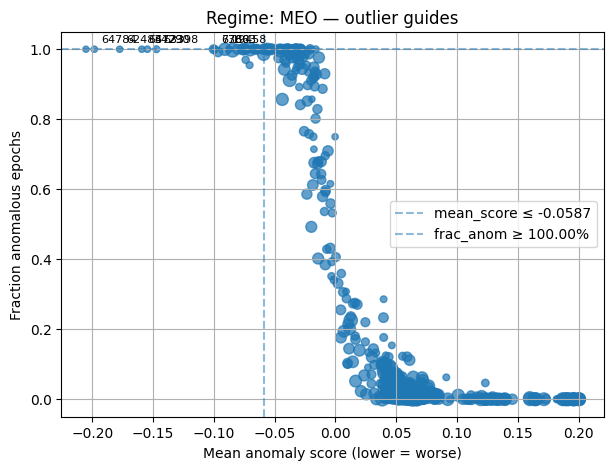

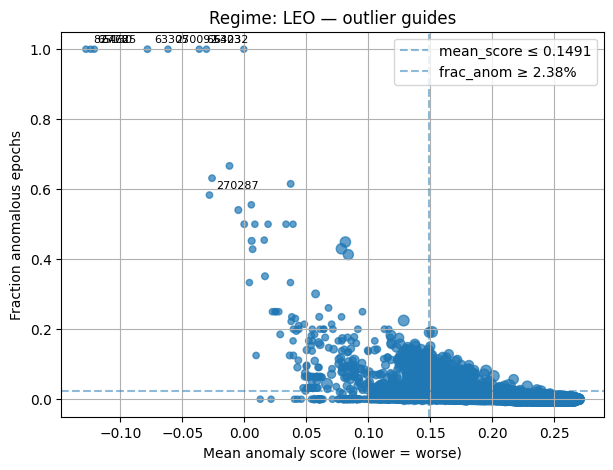

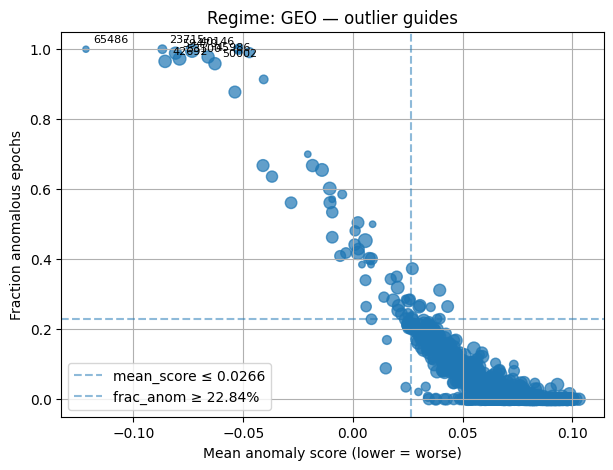

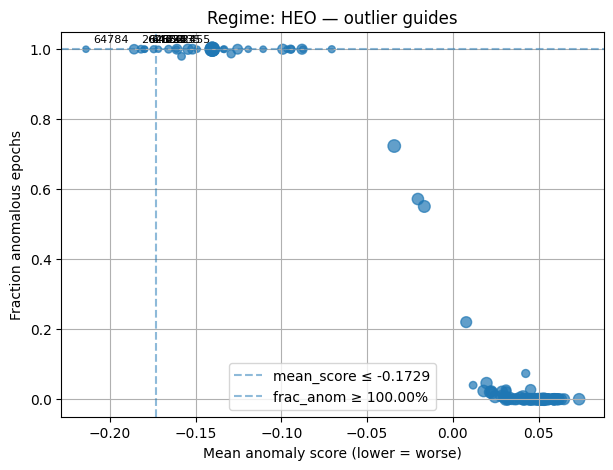

In [12]:
def plot_regime(reg):
    d = sr[sr["regime"] == reg].copy()
    if d.empty:
        print(f"No satellites in regime '{reg}'"); return
    ms_cut = d["mean_score_cut"].iloc[0]
    fa_cut = d["frac_anom_cut"].iloc[0]

    plt.figure(figsize=(7,5))
    plt.scatter(d["mean_score"], d["frac_anom"],
                s=20 + 80*d["n_obs"]/max(1,d["n_obs"].max()),
                alpha=0.7)
    plt.axvline(ms_cut, linestyle="--", alpha=0.5, label=f"mean_score ≤ {ms_cut:.4f}")
    plt.axhline(fa_cut, linestyle="--", alpha=0.5, label=f"frac_anom ≥ {fa_cut:.2%}")
    plt.xlabel("Mean anomaly score (lower = worse)")
    plt.ylabel("Fraction anomalous epochs")
    plt.title(f"Regime: {reg} — outlier guides")
    plt.grid(True)
    # label the worst few
    lab = d.sort_values(["flag_recent","flag_frac_high","mean_score"],
                        ascending=[False, False, True]).head(8)
    for _, r in lab.iterrows():
        plt.annotate(int(r["norad_id"]),
                     (r["mean_score"], r["frac_anom"]),
                     textcoords="offset points", xytext=(5,5), fontsize=8)
    plt.legend()
    plt.show()

for reg in sr["regime"].dropna().unique():
    plot_regime(reg)


## Robust, Regime-Calibrated Watchlist (with Wilson lower bounds)

This cell rebuilds the satellite rollup, adds a **Wilson lower-bound (WLB)** estimate for each satellite’s anomaly rate (safer for small `n`), then derives **regime-specific cutoffs** and flags to rank suspicious objects more reliably.

### 1) Rollup (includes counts for WLB)
Per (`norad_id`, `regime`) we compute:
- `mean_score`, `std_score` — central tendency & spread of anomaly scores  
- `n_obs` — total epochs
- `anom_k` — number of anomalous epochs (`is_anomaly == 1`)
- `frac_anom` — naive anomaly rate (`anom_k / n_obs`)
- Recency features: `last_epoch`, `recent_latch`, `recent_anom_count`, `recent_anom_frac`

> If 7-day fields are missing, harmless defaults (zeros) are injected so the pipeline runs.

### 2) Wilson lower bound (WLB) for anomaly rate
`frac_anom_wlb` ≈ conservative lower bound of the binomial proportion with **z=1.64 (~90% one-sided)**:
- Penalizes small sample sizes, avoiding overconfident high fractions when `n_obs` is tiny.
- Safer ranking than raw `frac_anom`, especially for sparse satellites.

### 3) Regime-aware cutoffs with stability guards
Hyperparameters:
- `MIN_OBS_PER_SAT = 10` (require at least 10 epochs to influence regime cuts)
- `MEAN_SCORE_Q = 0.05` (bottom 5% by `mean_score`)
- `FRAC_WLB_Q   = 0.95` (top 5% by `frac_anom_wlb`)
- `RECENT_FRAC_Q= 0.95` (top 5% by `recent_anom_frac`)
- `RECENT_CNT_MIN = 2`

For each `regime`, compute quantile cutoffs on satellites with `n_obs ≥ MIN_OBS_PER_SAT`.  
If a regime is too small or degenerate, **fallback** to quantiles on the full regime sample, and back off slightly if the cut hits the max (avoids everyone at the ceiling).

Outputs per regime:
- `mean_score_cut`, `frac_wlb_cut`, `recent_frac_cut`

### 4) Calibrated flags & risk score
- `flag_score_tail = 1{ mean_score ≤ mean_score_cut }`
- `flag_frac_high  = 1{ frac_anom_wlb ≥ frac_wlb_cut }`
- `flag_recent     = 1{ recent_anom_count ≥ 2  OR  recent_anom_frac ≥ recent_frac_cut }`

Risk (persistence weighted):
\[
\text{risk\_points\_regime} = 2\cdot \text{flag\_recent} + 1\cdot \text{flag\_score\_tail} + 1\cdot \text{flag\_frac\_high}
\]

### 5) Outputs
- **`cuts`**: per-regime thresholds (printed)
- **`watchlist_regime`**: satellites ranked by `risk_points_regime`, then by recency/fraction/score. Top 20 printed.

### Why this is sturdier
- **WLB** guards against small-`n` flukes.  
- **Per-regime quantiles** respect different operating behaviors (LEO vs GEO).  
- **Ceiling back-off** and **min-obs filters** prevent brittle thresholds.

### Tips / Extensions
- Add a **staleness penalty** using `last_epoch` (e.g., down-rank if older than 30–60 days).
- Expose **percentile ranks** per regime for `mean_score`, `frac_anom_wlb`, `recent_anom_frac` to aid review.
- Consider **object_type filters** (e.g., focus on `PAYLOAD`) upstream of this rollup.


In [13]:
feats = feats.copy()

# 1) Ensure we have a binary anomaly flag (1 = anomaly)
if "is_anomaly" not in feats.columns:
    if "anomaly_label" in feats.columns:
        feats["is_anomaly"] = (feats["anomaly_label"] == -1).astype(int)
    else:
        raise KeyError("Need 'is_anomaly' or 'anomaly_label' to compute anomaly counts.")

# 2) If 7-day fields are missing, add harmless defaults
for c in ["sat_7d_latch", "sat_7d_anom_count", "sat_7d_anom_frac"]:
    if c not in feats.columns:
        feats[c] = 0

# 3) Rebuild per-satellite rollup (includes anom_k)
sat_rollup = (
    feats.groupby(["norad_id","regime"], as_index=False)
         .agg(
             mean_score=("anomaly_score","mean"),
             std_score =("anomaly_score","std"),
             n_obs     =("is_anomaly","size"),
             anom_k    =("is_anomaly","sum"),
             frac_anom =("is_anomaly","mean"),
             last_epoch=("epoch","max"),
             recent_latch     =("sat_7d_latch","max"),
             recent_anom_count=("sat_7d_anom_count","max"),
             recent_anom_frac =("sat_7d_anom_frac","max"),
         )
)

# 4) Wilson lower bound for anomaly rate (robust vs small n)
def wilson_lb(k: int, n: int, z: float = 1.64):  # ≈90% lower bound
    if n <= 0:
        return 0.0
    p = k / n
    denom  = 1.0 + (z*z)/n
    centre = p + (z*z)/(2*n)
    adj    = z * sqrt((p*(1-p) + (z*z)/(4*n)) / n)
    return max(0.0, (centre - adj) / denom)

sat_rollup["frac_anom_wlb"] = [
    wilson_lb(int(k), int(n)) for k, n in zip(sat_rollup["anom_k"], sat_rollup["n_obs"])
]

# 5) Regime-calibrated, robust cutoffs
MIN_OBS_PER_SAT = 10
MEAN_SCORE_Q    = 0.05   # bottom 5% mean_score per regime
FRAC_WLB_Q      = 0.95   # top 5% Wilson-LB per regime
RECENT_FRAC_Q   = 0.95   # top 5% recent 7d frac per regime
RECENT_CNT_MIN  = 2

def quantile_or_fallback(s: pd.Series, q: float, fallback: float):
    s = s.dropna()
    if len(s) == 0:
        return fallback
    val = np.nanquantile(s, q)
    # Avoid degenerate 100% ceilings by backing off slightly
    if np.isclose(val, s.max(), atol=1e-12):
        return np.nanquantile(s, min(0.90, (q + 0.90)/2))
    return val

cuts = []
for reg, g in sat_rollup.groupby("regime"):
    gf = g[g["n_obs"] >= MIN_OBS_PER_SAT]
    ms_cut  = quantile_or_fallback(gf["mean_score"],      MEAN_SCORE_Q,  g["mean_score"].quantile(MEAN_SCORE_Q))
    wlb_cut = quantile_or_fallback(gf["frac_anom_wlb"],   FRAC_WLB_Q,    g["frac_anom_wlb"].quantile(FRAC_WLB_Q))
    rfc_cut = quantile_or_fallback(gf["recent_anom_frac"],RECENT_FRAC_Q, g["recent_anom_frac"].quantile(RECENT_FRAC_Q))
    cuts.append({"regime": reg, "mean_score_cut": ms_cut, "frac_wlb_cut": wlb_cut, "recent_frac_cut": rfc_cut})
cuts = pd.DataFrame(cuts)

# 6) Flags + regime-calibrated risk score
sr = sat_rollup.merge(cuts, on="regime", how="left")

sr["flag_score_tail"] = (sr["mean_score"]      <= sr["mean_score_cut"]).astype(int)
sr["flag_frac_high"]  = (sr["frac_anom_wlb"]   >= sr["frac_wlb_cut"]).astype(int)
sr["flag_recent"]     = ((sr["recent_anom_count"] >= RECENT_CNT_MIN) |
                         (sr["recent_anom_frac"]  >= sr["recent_frac_cut"])).astype(int)

sr["risk_points_regime"] = 2*sr["flag_recent"] + 1*sr["flag_score_tail"] + 1*sr["flag_frac_high"]

watchlist_regime = sr.sort_values(
    ["risk_points_regime","flag_recent","flag_frac_high","mean_score"],
    ascending=[False, False, False, True]
).reset_index(drop=True)

print("sat_rollup columns:", list(sat_rollup.columns))
print("\nPer-regime cuts:\n", cuts.sort_values("regime"))
print("\nTop 20 (regime-calibrated, robust):")
watchlist_regime.head(20)

sat_rollup columns: ['norad_id', 'regime', 'mean_score', 'std_score', 'n_obs', 'anom_k', 'frac_anom', 'last_epoch', 'recent_latch', 'recent_anom_count', 'recent_anom_frac', 'frac_anom_wlb']

Per-regime cuts:
   regime  mean_score_cut  frac_wlb_cut  recent_frac_cut
0    GEO        0.026757      0.187229         1.000000
1    HEO       -0.157951      0.984233         1.000000
2    LEO        0.151170      0.009753         0.277778
3    MEO       -0.052238      0.975809         1.000000

Top 20 (regime-calibrated, robust):


,norad_id,regime,mean_score,std_score,n_obs,anom_k,frac_anom,last_epoch,recent_latch,recent_anom_count,recent_anom_frac,frac_anom_wlb,mean_score_cut,frac_wlb_cut,recent_frac_cut,flag_score_tail,flag_frac_high,flag_recent,risk_points_regime
0,82778,LEO,-0.127703,0.032911,7,7,1.000000,2025-07-28 21:53:06+00:00,1,3,1.0,0.722424,0.151170,0.009753,0.277778,1,1,1,4
1,65130,LEO,-0.123914,0.003633,2,2,1.000000,2025-08-11 22:45:14.823936+00:00,1,2,1.0,0.426476,0.151170,0.009753,0.277778,1,1,1,4
2,65486,GEO,-0.121676,NaN,1,1,1.000000,2025-09-05 23:05:12.676992+00:00,1,1,1.0,0.271032,0.026757,0.187229,1.000000,1,1,1,4
3,64625,LEO,-0.120955,NaN,1,1,1.000000,2025-07-01 11:31:10.322976+00:00,1,1,1.0,0.271032,0.151170,0.009753,0.277778,1,1,1,4
4,19458,MEO,-0.090970,0.038705,278,278,1.000000,2025-09-05 01:55:52.718592+00:00,1,18,1.0,0.990418,-0.052238,0.975809,1.000000,1,1,1,4
5,23715,GEO,-0.086838,0.033692,115,115,1.000000,2025-09-04 23:08:36.007296+00:00,1,10,1.0,0.977147,0.026757,0.187229,1.000000,1,1,1,4
6,42692,GEO,-0.085601,0.042806,375,362,0.965333,2025-09-05 06:00:59.824224+00:00,1,24,1.0,0.946231,0.026757,0.187229,1.000000,1,1,1,4
7,37206,MEO,-0.084645,0.031777,369,368,0.997290,2025-09-05 18:12:18.345024+00:00,1,20,1.0,0.987990,-0.052238,0.975809,1.000000,1,1,1,4
8,59479,GEO,-0.080860,0.034372,357,353,0.988796,2025-09-05 11:19:48.627840+00:00,1,18,1.0,0.975332,0.026757,0.187229,1.000000,1,1,1,4
9,13070,MEO,-0.080685,0.033780,148,148,1.000000,2025-09-04 23:12:29.538720+00:00,1,13,1.0,0.982151,-0.052238,0.975809,1.000000,1,1,1,4


## 9) Suspiciousness Scores (0–100) + Exports

This cell converts satellite rollups into an interpretable **0–100 suspiciousness score** that is **calibrated within each orbital regime** (LEO/MEO/GEO/HEO). Higher = more suspicious.

### Inputs & Fallback
- Expects `sr` (sat_rollup merged with per-regime cuts).  
- If missing, falls back to `sat_rollup` (works, but lacks some calibrated fields).

### How the score is built (`score_regime`)
Within each **regime**, compute percentile-ranked components (0–1), then weight and sum:
- **`ms_comp`** = 1 − rank(`mean_score`) → lower mean score ⇒ higher suspicion.
- **`wlb_comp`** = rank(`frac_anom_wlb`) → conservative anomaly rate via **Wilson lower bound**.
- **`recentf_comp`** = rank(`recent_anom_frac`) → recent (7-day) anomaly intensity.
- **`cnt_comp`** = `recent_anom_count` / max count in regime → normalized recency count.
- **`latch_comp`** = `recent_latch` ∈ {0,1} → any recent anomaly triggers a boost.

**Weights (tune to taste; persistence emphasized):**
\[
\text{susp\_0\_1} =
0.35\,\text{ms} +
0.30\,\text{wlb} +
0.25\,\text{recent\_frac} +
0.10\,\text{cnt} +
0.10\,\text{latch}
\quad\Rightarrow\quad
\text{suspiciousness} = 100 \cdot \text{susp\_0\_1}
\]
Scores are clipped to **[0, 100]**.

### Outputs
- **`watchlist_scored`**: all satellites ranked by `suspiciousness` (tie-break with `risk_points_regime`, then `mean_score`). Prints top 20 with key columns.
- **`topk_per_regime`**: top 10 per regime.

### Optional reliability down-weighting
Commented example scales scores by coverage:
- `reliability = min(1, n_obs/20)`  
- `suspiciousness_adj = suspiciousness * reliability`  
Helps avoid over-ranking satellites with tiny sample sizes.

### Exports
- `../data/out/watchlist_regime_scored.csv`
- `../data/out/watchlist_regime_top10.csv`

### Notes / Tips
- Because components are **percentiles within regime**, scores are **comparable across regimes** and robust to distribution shifts.
- Consider adding `object_type` or mission metadata for targeted watchlists (e.g., focus on `PAYLOAD` only).
- For dashboards, keep both raw and adjusted scores to let reviewers toggle reliability weighting.

In [14]:
# === Regime-calibrated suspiciousness score (0–100) + exports ===

# Expect `sr` from prior cell (sat_rollup merged with per-regime cuts).
# If not present, fall back to sat_rollup (will be less informative).
base = sr if 'sr' in globals() else sat_rollup.copy()

def score_regime(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a 0–100 suspiciousness score within each regime.
    Higher = more suspicious. Uses percentile ranks so scales per-regime.
    """
    parts = []
    for reg, g in df.groupby("regime", dropna=False):
        gg = g.copy()

        # Components (all 0..1 via percentile rank, except latch/count which we normalize)
        ms_comp      = 1.0 - gg["mean_score"].rank(pct=True, method="average")              # lower mean_score -> higher suspicious
        wlb_comp     = gg["frac_anom_wlb"].rank(pct=True, method="average").fillna(0.0)     # higher Wilson-LB -> higher suspicious
        recentf_comp = gg["recent_anom_frac"].rank(pct=True, method="average").fillna(0.0)  # higher recent frac -> higher suspicious

        # Normalize counts and latch inside regime
        max_cnt = max(1, float(gg["recent_anom_count"].max() if "recent_anom_count" in gg else 1))
        cnt_comp   = (gg.get("recent_anom_count", 0) / max_cnt).fillna(0.0)
        latch_comp = gg.get("recent_latch", 0).fillna(0.0).astype(float)

        # Weighting (tweak to taste; persistence emphasized)
        susp_0_1 = (
            0.35*ms_comp +
            0.30*wlb_comp +
            0.25*recentf_comp +
            0.10*cnt_comp +
            0.10*latch_comp
        )

        gg["suspiciousness"] = (100.0 * susp_0_1).clip(0, 100)
        parts.append(gg)

    return pd.concat(parts, ignore_index=True)

watchlist_scored = score_regime(base).sort_values(
    ["suspiciousness","risk_points_regime","mean_score"],
    ascending=[False, False, True]
).reset_index(drop=True)

# Show top 20 overall
cols = ["norad_id","regime","suspiciousness","risk_points_regime",
        "mean_score","frac_anom_wlb","recent_anom_frac","recent_anom_count","n_obs"]
print(watchlist_scored[cols].head(20))

# Top 10 per regime
topk_per_regime = (watchlist_scored
                   .sort_values("suspiciousness", ascending=False)
                   .groupby("regime", dropna=False)
                   .head(10)
                   .reset_index(drop=True))
topk_per_regime[cols]

# Optional: down-weight tiny samples by reliability and re-rank (uncomment to use)
# reliability = np.minimum(1.0, watchlist_scored["n_obs"] / 20.0)  # saturate at 20 epochs
# watchlist_scored["suspiciousness_adj"] = (watchlist_scored["suspiciousness"] * reliability).round(2)
# watchlist_scored = watchlist_scored.sort_values(["suspiciousness_adj","suspiciousness"], ascending=[False, False])

# # Export
# watchlist_scored.to_csv("../data/out/watchlist_regime_scored.csv", index=False)
# topk_per_regime.to_csv("../data/out/watchlist_regime_top10.csv", index=False)
# print("Saved: ../data/out/watchlist_regime_scored.csv and ../data/out/watchlist_regime_top10.csv")

    norad_id regime  suspiciousness  risk_points_regime  mean_score  \
0      82778    LEO           100.0                   4   -0.127703   
1      65130    LEO           100.0                   4   -0.123914   
2      64625    LEO           100.0                   4   -0.120955   
3      19458    MEO           100.0                   4   -0.090970   
4      23715    GEO           100.0                   4   -0.086838   
5      42692    GEO           100.0                   4   -0.085601   
6      37206    MEO           100.0                   4   -0.084645   
7      59479    GEO           100.0                   4   -0.080860   
8      13070    MEO           100.0                   4   -0.080685   
9      53100    GEO           100.0                   4   -0.079009   
10     63305    LEO           100.0                   4   -0.078129   
11     20712    MEO           100.0                   4   -0.075832   
12     26609    MEO           100.0                   4   -0.075613   
13    

,norad_id,regime,suspiciousness,risk_points_regime,mean_score,frac_anom_wlb,recent_anom_frac,recent_anom_count,n_obs
0,82778,LEO,100.000000,4,-0.127703,0.722424,1.000000,3,7
1,61604,LEO,100.000000,4,0.148217,0.049032,0.666667,14,388
2,64818,LEO,100.000000,4,0.147996,0.060426,0.588235,11,126
3,64426,LEO,100.000000,4,0.147887,0.079570,0.842105,16,198
4,64023,LEO,100.000000,4,0.147713,0.101689,0.843750,27,282
5,64506,LEO,100.000000,4,0.147648,0.054158,0.611111,11,184
6,63948,LEO,100.000000,4,0.146702,0.051567,0.575758,19,304
7,64432,LEO,100.000000,4,0.146639,0.088412,0.950000,19,207
8,64431,LEO,100.000000,4,0.146520,0.098186,1.000000,20,204
9,64417,LEO,100.000000,4,0.146270,0.087827,0.809524,17,218


In [15]:
watchlist_scored.columns

Index(['norad_id', 'regime', 'mean_score', 'std_score', 'n_obs', 'anom_k',
       'frac_anom', 'last_epoch', 'recent_latch', 'recent_anom_count',
       'recent_anom_frac', 'frac_anom_wlb', 'mean_score_cut', 'frac_wlb_cut',
       'recent_frac_cut', 'flag_score_tail', 'flag_frac_high', 'flag_recent',
       'risk_points_regime', 'suspiciousness'],
      dtype='object')

## 10) Daily Facts Table (+ 7-Day Windows) for Power BI

This cell rolls per-epoch anomalies into **per-satellite, per-day** aggregates and adds **7-day window** metrics that Power BI can slice easily.

### Inputs & Validation
- Requires: `norad_id`, `epoch`, `anomaly_score`
- Ensures `epoch` is UTC datetime, sorts by `norad_id, epoch`
- Creates `regime = "UNKNOWN"` if missing
- Ensures binary `is_anomaly` (from `anomaly_label == -1` if needed)

### Daily Aggregation
Grouped by `norad_id, regime, day` (where `day = floor(epoch,'D')`):
- `n_obs_day` — total epochs that day
- `n_anom_day` — anomalous epochs
- `frac_anom_day` — share anomalous
- `mean_score_day`, `min_score_day`, `max_score_day` — daily anomaly score stats
- `any_anom_day` — 1 if any anomaly that day

### Robust 7-Day Window (cumulative-sum + merge_asof)
For each satellite:
- Build cumulative sums (`cum_obs`, `cum_anom`)
- For each `day`, look up cumulative values **7 days prior** via `merge_asof`
- Window metrics (last 7 days):
  - `day_7d_obs` (implicit, used for fraction)
  - `day_7d_anom_count`
  - `day_7d_latch` = 1 if any anomalies in last 7 days
  - `day_7d_anom_frac` = count / obs (denominator guarded with `max(...,1)`)

### Output Schema (`fact_daily.csv`)
- `norad_id, regime, day`
- `n_obs_day, n_anom_day, frac_anom_day`
- `mean_score_day, min_score_day, max_score_day`
- `any_anom_day, day_7d_latch, day_7d_anom_count, day_7d_anom_frac`

### Notes / Gotchas
- Handles irregular sampling; the 7-day window is **calendar-based**, not fixed row count.
- If early days have <7 days of history, window falls back to available range.
- Converts `day` to a plain `date` for easy **Power BI** joins to a calendar table.

### Export
Writes to `../data/out/fact_daily.csv` and prints the path + row count.


In [16]:
df = feats.copy()

# Required columns
need = ["norad_id","epoch","anomaly_score"]
miss = [c for c in need if c not in df.columns]
if miss:
    raise KeyError(f"Missing columns in feats for daily export: {miss}")

# Ensure epoch is datetime and sorted
df["epoch"] = pd.to_datetime(df["epoch"], utc=True, errors="coerce")
df = df.dropna(subset=["epoch","norad_id"]).sort_values(["norad_id","epoch"]).reset_index(drop=True)

# Regime fallback (if absent)
if "regime" not in df.columns:
    df["regime"] = "UNKNOWN"

# Binary anomaly flag
if "is_anomaly" not in df.columns:
    if "anomaly_label" in df.columns:
        df["is_anomaly"] = (df["anomaly_label"] == -1).astype(int)
    else:
        raise KeyError("Need 'is_anomaly' or 'anomaly_label' to build daily fact.")

# Day key (keep as Timestamp for now)
df["day"] = df["epoch"].dt.floor("D")

# --- Aggregate to per-day stats ---
daily = (
    df.groupby(["norad_id","regime","day"], as_index=False)
      .agg(
          n_obs_day      = ("is_anomaly","size"),
          n_anom_day     = ("is_anomaly","sum"),
          frac_anom_day  = ("is_anomaly","mean"),
          mean_score_day = ("anomaly_score","mean"),
          min_score_day  = ("anomaly_score","min"),
          max_score_day  = ("anomaly_score","max"),
      )
      .sort_values(["norad_id","regime","day"])
      .reset_index(drop=True)
)
daily["any_anom_day"] = (daily["n_anom_day"] > 0).astype(int)

# --- Robust 7-day window using cumulative sums + merge_asof ---
def add_7d_day_metrics_cumsum(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values("day").copy()
    # Ensure datetime index (naive is fine here)
    g["day"] = pd.to_datetime(g["day"])
    # Cumulative sums
    g["cum_obs"]  = g["n_obs_day"].cumsum()
    g["cum_anom"] = g["n_anom_day"].cumsum()

    # Build a reference table to look up cumulative sums at window start
    ref = g[["day","cum_obs","cum_anom"]].rename(columns={"day":"ref_day"}).copy()

    # Window starts are 7 days before current day (exclusive of earlier rows)
    starts = g["day"] - pd.Timedelta(days=7)

    # For each row, find the last cumulative value at or before 'start'
    prev = pd.merge_asof(
        left=pd.DataFrame({"ref_day": starts}),
        right=ref.sort_values("ref_day"),
        on="ref_day",
        direction="backward"
    ).fillna({"cum_obs": 0, "cum_anom": 0})

    # Window sums = current cum - cum_at_start
    g["day_7d_obs"]        = (g["cum_obs"]  - prev["cum_obs"].to_numpy()).astype(int)
    g["day_7d_anom_count"] = (g["cum_anom"] - prev["cum_anom"].to_numpy()).astype(int)
    g["day_7d_latch"]      = (g["day_7d_anom_count"] > 0).astype(int)
    g["day_7d_anom_frac"]  = (g["day_7d_anom_count"] / np.maximum(g["day_7d_obs"], 1)).astype(float)

    # Clean up helpers
    g.drop(columns=["cum_obs","cum_anom"], inplace=True)
    return g

daily = (
    daily.groupby(["norad_id","regime"], group_keys=False)
         .apply(add_7d_day_metrics_cumsum)
         .reset_index(drop=True)
)

# Convert 'day' to plain date for Power BI
daily["day"] = daily["day"].dt.date

# Reorder / select export columns
daily_cols = [
    "norad_id","regime","day",
    "n_obs_day","n_anom_day","frac_anom_day",
    "mean_score_day","min_score_day","max_score_day",
    "any_anom_day","day_7d_latch","day_7d_anom_count","day_7d_anom_frac"
]
fact_daily = daily[daily_cols].copy()

# Save
daily_path = os.path.join(OUT_DIR, "dailies.csv")
fact_daily.to_csv(daily_path, index=False)

print("Saved:", daily_path, "| Rows:", len(fact_daily))

C:\Users\Dd\AppData\Local\Temp\ipykernel_27120\4197971860.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_7d_day_metrics_cumsum)


Saved: ..\data\out\dailies.csv | Rows: 2488026


In [17]:
fact_daily.columns

Index(['norad_id', 'regime', 'day', 'n_obs_day', 'n_anom_day', 'frac_anom_day',
       'mean_score_day', 'min_score_day', 'max_score_day', 'any_anom_day',
       'day_7d_latch', 'day_7d_anom_count', 'day_7d_anom_frac'],
      dtype='object')

In [18]:
# 1. Find duplicated norad_id values
dupes = watchlist_scored[watchlist_scored.duplicated('norad_id', keep=False)]

# 2. Sort for readability
dupes = dupes.sort_values(by='norad_id')

dupes

,norad_id,regime,mean_score,std_score,n_obs,anom_k,frac_anom,last_epoch,recent_latch,recent_anom_count,recent_anom_frac,frac_anom_wlb,mean_score_cut,frac_wlb_cut,recent_frac_cut,flag_score_tail,flag_frac_high,flag_recent,risk_points_regime,suspiciousness
2655,28946,GEO,0.082958,0.034174,173,8,0.046243,2025-06-09 06:48:44.745408+00:00,1,10,0.909091,0.026292,0.026757,0.187229,1.000000,0,0,1,2,65.560382
2587,28946,HEO,0.045285,0.022442,184,5,0.027174,2025-09-05 20:58:51.745728+00:00,1,11,1.000000,0.013316,-0.157951,0.984233,1.000000,0,0,1,2,68.404876
2585,40547,HEO,0.042441,0.040747,68,5,0.073529,2025-09-05 17:36:04.767264+00:00,1,5,1.000000,0.036321,-0.157951,0.984233,1.000000,0,0,1,2,68.463255
2445,40547,GEO,0.065859,0.025309,121,5,0.041322,2025-07-08 17:59:34.334016+00:00,1,3,1.000000,0.020298,0.026757,0.187229,1.000000,0,0,1,2,76.521611
2149,44625,HEO,-0.179838,0.002400,3,3,1.000000,2025-04-20 09:53:51.384192+00:00,1,8,0.470588,0.527278,-0.157951,0.984233,1.000000,1,0,1,3,84.684066
44,44625,GEO,0.001006,0.064052,212,102,0.481132,2025-07-31 22:27:50.430240+00:00,1,19,1.000000,0.425444,0.026757,0.187229,1.000000,1,1,1,4,100.000000
1248,62455,HEO,-0.165683,0.030946,54,54,1.000000,2025-06-30 08:10:44.298336+00:00,1,8,1.000000,0.952556,-0.157951,0.984233,1.000000,1,0,1,3,92.965316
2155,62455,GEO,0.056775,0.053761,117,10,0.085470,2025-09-05 20:41:14.696160+00:00,1,6,1.000000,0.051852,0.026757,0.187229,1.000000,0,0,1,2,84.584622
1560,62456,GEO,0.045420,0.074649,74,11,0.148649,2025-09-05 21:48:09.519264+00:00,1,6,1.000000,0.093220,0.026757,0.187229,1.000000,0,0,1,2,90.870795
1728,62456,HEO,-0.129200,0.064080,77,76,0.987013,2025-07-17 12:22:47.335296+00:00,1,12,1.000000,0.944065,-0.157951,0.984233,1.000000,0,0,1,2,89.593063


## Deduplicate to Latest Snapshot per Satellite

Some satellites may appear multiple times in the scored watchlist (e.g., if merged across updates or epochs).  
To avoid duplicates, we keep **only the most recent record per `norad_id`**.

### Steps
1. Convert `last_epoch` to datetime (`NaT` if parsing fails).  
2. Sort by `last_epoch` ascending.  
3. Drop duplicates on `norad_id`, keeping the **last** (most recent) row.  
4. Reset the index for a clean frame.

### Output
- `deduped` = one row per `norad_id` (latest only).  
- `.shape` prints `(rows, cols)` so you can verify how many satellites remain after deduplication.

In [19]:
# Ensure last_epoch is datetime
watchlist_scored['last_epoch'] = pd.to_datetime(watchlist_scored['last_epoch'], errors='coerce')

# Keep only the latest row per norad_id
deduped = (
    watchlist_scored.sort_values('last_epoch')
    .drop_duplicates(subset='norad_id', keep='last')
    .reset_index(drop=True)
)

deduped.shape

(16457, 20)

## 10) Export Final Scores

The deduplicated, most-recent snapshot per satellite is now exported as the **final scores table**.

- **Source**: `deduped` (latest row per `norad_id`)  
- **Destination**: `../data/out/scores.csv`  
- **Format**: CSV, no index

This file is the **master watchlist with suspiciousness scores**, ready for:
- Power BI dashboards  
- Further analysis / sharing  
- Archival for reproducibility

In [20]:
deduped.to_csv(OUTPUT_SCORES, index=False)